<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/ViT/vanilla_vision_transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference:](https://medium.com/@pashashaik/part-1-building-vision-transformers-from-scratch-a-pytorch-deep-dive-plus-a-teaser-on-lora-for-beef0f3aef5c)

Paper: [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf)

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [2]:
from dataclasses import dataclass
@dataclass
class ModelArgs:
    dim : int = 256 #dim of model embeddings
    hidden_dim :int = 512 #feed forward hidden dim
    n_heads = 8
    n_layers = 6
    patch_size:int = 4
    n_channels = 3
    n_classes:int = 10
    dropout:float = 0.2
    n_patches = 64

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self,args:ModelArgs):
        super().__init__()

        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim,args.dim,bias = False)
        self.wk = nn.Linear(args.dim,args.dim,bias = False)
        self.wv = nn.Linear(args.dim,args.dim,bias = False)
        self.wo = nn.Linear(args.dim,args.dim,bias = False)

    def forward(self,x):
        b,seq_len,dim = x.shape
        q = self.wq(x) #[b,seq_len,n_heads*h_dim]
        k = self.wk(x) #[b,seq_len,n_heads*h_dim]
        v = self.wv(x) #[b,seq_len,n_heads*h_dim]

        q = q.view(b,seq_len,self.n_heads,self.head_dim) #[b,seq_len,n_heads,h_dim]
        k = k.view(b,seq_len,self.n_heads,self.head_dim)
        v = v.view(b,seq_len,self.n_heads,self.head_dim)
        q = q.transpose(1,2) #[b,n_heads,seq_len,h_dim]
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        attn =  torch.matmul(q,k.transpose(2,3)) / math.sqrt(self.head_dim) #[b,n_heads,seq_len,seq_len]
        attn_scores = F.softmax(attn,dim = -1)

        #compute attended features
        out = torch.matmul(attn_scores,v) #[b,n_heads,seq_len,h_dim]

        out = out.view(b,seq_len,-1) #[b,seq_len,n_heads * head_dim]

        #out = out.transpose(1,2).contiguous().view(b,seq_len,dim)

        out = self.wo(out) #[b,seq_len,dim]
        return out

In [4]:

class AttentionBlock(nn.Module):
    def __init__(self,args:ModelArgs):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(args.dim)
        self.attn = MultiHeadAttention(args)
        self.layer_norm_2 = nn.LayerNorm(args.dim)
        self.ffn = nn.Sequential(
            nn.Linear(args.dim,args.hidden_dim),
            nn.GELU(),
            nn.Dropout(args.dropout),
            nn.Linear(args.hidden_dim,args.dim),
            nn.Dropout(args.dropout)
        )
    def forward(self,x):
        x = x + self.attn(self.layer_norm_1(x))
        x = x + self.ffn(self.layer_norm_2(x))
        return x

Coverting images image into patches

In [5]:
def img_to_patches(x,patch_size,flatten_channels = True):
    B,C,H,W = x.shape

    #reshape image into non overlapping patches
    x = x.reshape(B,C,H//patch_size,patch_size,W//patch_size,patch_size)

    #permute to group the patches and channels
    x = x.permute(0,2,4,1,3,5) #[B,H/patch_size,W/patch_size,C,patch_size,patch_size]

    x = x.flatten(1,2) #[B,(H/patch_size * W/patch_size),C ,patch_size ,patch_size]

    if flatten_channels:
        x = x.flatten(2,4) #[B,(H/patch_size * W/patch_size),(C *patch_size *patch_size)]

    return x

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self,args):
        super().__init__()

        self.patch_size = args.patch_size

        patch_dim = args.n_channels * args.patch_size ** 2
        self.input_layer = nn.Linear(patch_dim,args.dim)

        attn_blocks = []
        for _ in range(args.n_layers):
            attn_blocks.append(AttentionBlock(args))

        self.transformer = nn.Sequential(*attn_blocks)

        self.mlp = nn.Sequential(
            nn.LayerNorm(args.dim),
            nn.Linear(args.dim,args.n_classes)
        )

        self.dropout = nn.Dropout(args.dropout)

        self.cls_token = nn.Parameter(torch.randn(1,1,args.dim))
        #n_patches = (img_W * img_H) / patch_size ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1,1 + args.n_patches,args.dim))
    def forward(self,x):
        #convert img to patches and flatten
        x = img_to_patches(x,self.patch_size)
        b,seq_len,_ = x.shape


        #transform patches using embedding layer
        x = self.input_layer(x)

        #add the class token to beggining of each seq
        cls_token = self.cls_token.repeat(b,1,1)

        x = torch.cat([cls_token,x],dim = 1)

        x = x + self.pos_embedding[:,:seq_len + 1]

        x = self.dropout(x)

        x = self.transformer(x)

        x = x.transpose(0,1)

        # Retrieve the class token's representation (for classification)
        cls = x[0]
        # Classify using the representation of the class token
        out = self.mlp(cls)

        return out

Data and dataloaders

In [7]:
from torchvision import transforms, datasets

In [8]:
DATA_DIR = "../data"
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])
train_dataset = datasets.CIFAR10(root = DATA_DIR,train = True,transform = train_transform,download = True)
test_dataset = datasets.CIFAR10(root = DATA_DIR,train = False , transform = test_transform,download = True)

train_set,val_set = torch.utils.data.random_split(train_dataset,[45000,5000])

100%|██████████| 170498071/170498071 [00:03<00:00, 43863638.47it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Let’s setup the data loaders for training, validation and test datasets

In [9]:
batch_size = 16
# Define the number of subprocesses to use for data loading.
num_workers = 4

# Create a DataLoader for the training and validation dataset:
# 1. Shuffle the training data for each epoch.
# 2. Drop the last batch if its size is not equal to `batch_size` to maintain consistency.
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = num_workers,
                                           drop_last = True)

# Do not drop any data; process all the validation data.
val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers,
                                         drop_last=False)
# Create a DataLoader for the testing dataset:
# Do not drop any data; process all the test data.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          drop_last=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


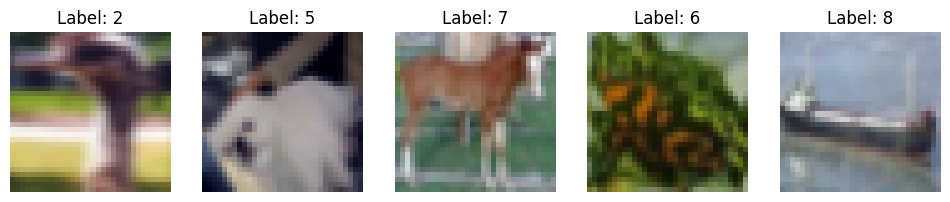

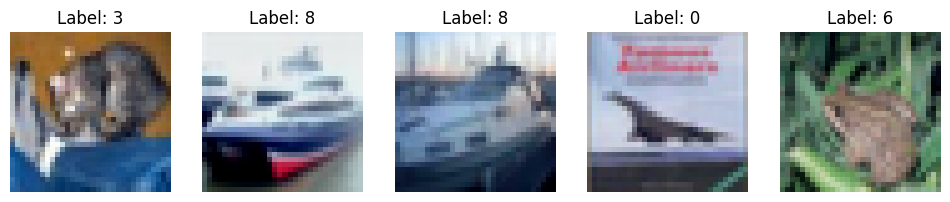

In [10]:
import matplotlib.pyplot as plt

# Assuming you have imported necessary libraries and defined your datasets already

# Create a function to display images
def show_images(dataset, num_images=5):
    # Set up a figure with the specified number of subplots
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        # Get an image and its label from the dataset
        image, label = dataset[i]

        # Unnormalize the image to display it properly
        image = (image * 0.26158784) + 0.44653091  # Unnormalize using the CIFAR-10 statistics

        # Transpose the image  (C, H, W) -> (H,W,C) format for displaying
        image = image.permute(1, 2, 0)

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Show examples from the training dataset
show_images(train_set)

# Show examples from the test dataset
show_images(test_dataset)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = ModelArgs()
model = VisionTransformer(args).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),3e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 130], gamma=0.1)

In [12]:
from tqdm import tqdm

In [21]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i,(imgs,labels) in enumerate(tqdm(train_loader)):
        imgs,labels = imgs.to(device),labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs,labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch : [{epoch+1} / {num_epochs}] ,Train loss :{avg_train_loss:.4f}")

    #validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs,labels in tqdm(val_loader):
            imgs,labels = imgs.to(device),labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)

            total_val_loss += loss.item()
            predicted = outputs.argmax(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    # Update the learning rate
    lr_scheduler.step()

print("Training complete!")

100%|██████████| 2812/2812 [01:17<00:00, 36.11it/s]


Epoch : [1 / 5] ,Train loss :1.1154


100%|██████████| 313/313 [00:04<00:00, 65.45it/s]


Epoch [1/5], Validation Loss: 1.1718, Validation Accuracy: 58.34%


100%|██████████| 2812/2812 [01:17<00:00, 36.20it/s]


Epoch : [2 / 5] ,Train loss :1.0921


100%|██████████| 313/313 [00:05<00:00, 54.40it/s]


Epoch [2/5], Validation Loss: 1.1296, Validation Accuracy: 60.08%


100%|██████████| 2812/2812 [01:17<00:00, 36.43it/s]


Epoch : [3 / 5] ,Train loss :1.0652


100%|██████████| 313/313 [00:04<00:00, 69.50it/s]


Epoch [3/5], Validation Loss: 1.1057, Validation Accuracy: 61.58%


100%|██████████| 2812/2812 [01:17<00:00, 36.24it/s]


Epoch : [4 / 5] ,Train loss :1.0446


100%|██████████| 313/313 [00:05<00:00, 57.26it/s]


Epoch [4/5], Validation Loss: 1.0778, Validation Accuracy: 61.86%


100%|██████████| 2812/2812 [01:18<00:00, 36.04it/s]


Epoch : [5 / 5] ,Train loss :1.0210


100%|██████████| 313/313 [00:04<00:00, 69.18it/s]

Epoch [5/5], Validation Loss: 1.0720, Validation Accuracy: 62.34%
Training complete!


In [22]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = outputs.max(dim=-1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 63.34%


Test Accuracy: 1140.00%


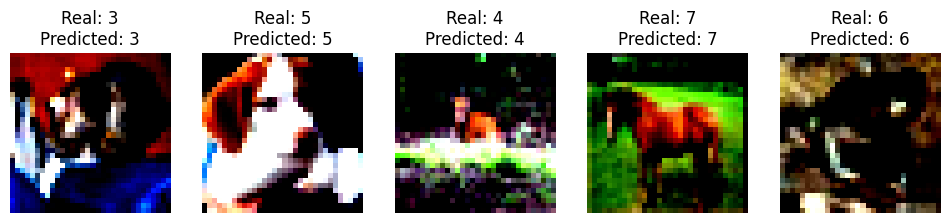

In [27]:
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

# Choose the number of images you want to plot
num_images_to_plot = 5

# Create a figure for plotting
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(12, 3))

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        if i >= num_images_to_plot:
            break

        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = outputs.max(dim=-1)
        image_label = labels[0].item()
        predicted_label = predicted[0].item()

        # Convert the image tensor to a NumPy array
        image = inputs[0].cpu().numpy().transpose((1, 2, 0))

        # Display the image
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f'Real: {image_label}\nPredicted: {predicted_label}')
        ax.axis('off')
        # Update accuracy variables

        total += 1
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

plt.show()  # Show the plot with selected images and labels


Test Accuracy: 67.97%


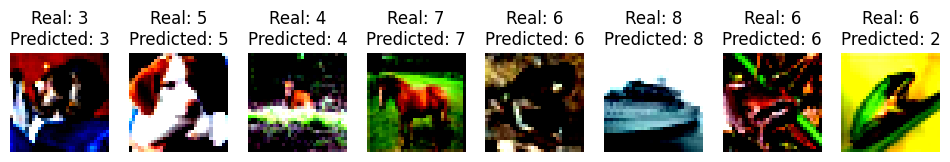

In [32]:
import matplotlib.pyplot as plt

model.eval()
correct = 0
total = 0

# Choose the number of images you want to plot
num_images_to_plot = 8

# Create a figure for plotting
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(12, 3))

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        if i >= num_images_to_plot:
            break

        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = outputs.max(dim=-1)
        image_label = labels[0].item()
        predicted_label = predicted[0].item()

        # Convert the image tensor to a NumPy array
        image = inputs[0].cpu().numpy().transpose((1, 2, 0))

        # Display the image
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f'Real: {image_label}\nPredicted: {predicted_label}')
        ax.axis('off')

        # Update accuracy variables
        total += labels.size(0)  # Update the total count with the batch size
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

plt.show()  # Show the plot with selected images and labels
